In [1]:
from mnist import MNIST
import pickle

import numpy as np

import json

import matplotlib.pyplot as plt

from src.NeuralNetwork import *
import src.DataHandler as dhm
import src.Analysis as analys
%matplotlib notebook

dataSet = 'mnist'

splitRate = 0.7


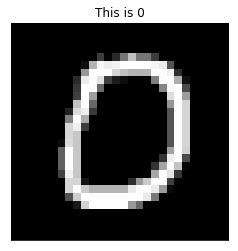

Normalization...


100% (10000 of 10000) |###################| Elapsed Time: 0:00:00 Time: 0:00:00


Size of learning data set: 7000
Size of validation data set: 3000
Size of testing data set: 10000


In [2]:
dh = dhm.DataHandler()

viewImageIndex = 10

images_train = []
labels_train = []
images_test = []
labels_test = []

if dataSet == 'mnist':
    
    path = 'data/mnist'
    
    mndata = MNIST(path)

    images_train, labels_train = mndata.load_training()
    images_test, labels_test = mndata.load_testing()

    pixels = np.array(images_test[viewImageIndex]).reshape(28,28)
    
    
if dataSet == 'cifar': 
    
    path = 'data/cifar/'
    
    files = ['data_batch_1' , 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
    
    for file in files:
    
        f = open(path + file, 'rb')
        tupled_data= pickle.load(f, encoding='bytes')
    
        f.close()
        
        images_train += tupled_data[b'data'].tolist()
        labels_train += tupled_data[b'labels']
        
            
    f = open(path + 'test_batch', 'rb')
    tupled_data= pickle.load(f, encoding='bytes')

    f.close()

    images_test = tupled_data[b'data'].tolist()
    labels_test = tupled_data[b'labels']    
    
    images_train = [dh.toYCbCr(pixels) for pixels in images_train]
    images_test = [dh.toYCbCr(pixels) for pixels in images_test]
    
    #pixels = np.transpose(np.reshape(tupled_data[b'data'][viewImageIndex],(3, 32,32)), (1,2,0))
    pixels = images_test[viewImageIndex]
    
    #pixels = dh.toYCbCr(pixels)
    
    pixels = np.array(pixels).reshape(32,32)    
    
label = labels_test[viewImageIndex]

plt.figure()
plt.imshow(pixels, cmap = 'gray')
plt.title('This is ' + str(label))
plt.xticks([])
plt.yticks([])
plt.show()

images_train = images_train[:10000]
labels_train = labels_train[:10000]

images_train = dh.maxNorm(images_train,_max = 255)

images_train, images_val = dh.split(images_train, rate = splitRate)
labels_train, labels_val = dh.split(labels_train, rate = splitRate)
    
print("Size of learning data set: " + str(len(images_train)))
print("Size of validation data set: " + str(len(images_val)))
print("Size of testing data set: " + str(len(images_test)))

In [ ]:
input_dim = len(images_train[0])
output_dim = int(10)


model = Sequental(input_dim)
model.add(Dense(64, activation = 'relu', dropoutProp = 0.))
model.add(Dense(32, activation = 'linear', dropoutProp = 0.))
model.add(Dense(32, activation = 'relu', dropoutProp = 0.))
model.add(Dense(16, activation = 'linear', dropoutProp = 0.))
model.add(Dense(output_dim, activation = 'sigmoid', dropoutProp = 0.))

In [ ]:
history = model.fit(images_train, labels_train, images_val, labels_val,
          numOfEpochs = 100, earlyStopAcc = 0.001,
          lossMetric = 'MSE', optimizerType = 'backProp',
          batchSize = 100, learningRate = 0.1,
          momentum = 0, patience = 3)

Start Learning...


100% (70.0 of 70.0) |#####################| Elapsed Time: 0:00:29 Time: 0:00:29


Evaluating...


 98% (6912 of 7000) |#################### | Elapsed Time: 0:00:05 ETA:  0:00:00

Evaluating...


 97% (2925 of 3000) |#################### | Elapsed Time: 0:00:02 ETA:  0:00:00

Epoch: 1/100 - loss(MSE): 0.0757341326498 - accuracy: 0.3434285714285714 - val_loss(MSE): 0.0760670025524 - val_accuracy: 0.3446666666666667


100% (70.0 of 70.0) |#####################| Elapsed Time: 0:00:31 Time: 0:00:31


Evaluating...


 99% (6994 of 7000) |#################### | Elapsed Time: 0:00:05 ETA:  0:00:00

Evaluating...


 98% (2963 of 3000) |#################### | Elapsed Time: 0:00:03 ETA:  0:00:00

Epoch: 2/100 - loss(MSE): 0.0653663894001 - accuracy: 0.4695714285714286 - val_loss(MSE): 0.066059802769 - val_accuracy: 0.472


 32% (23 of 70.0) |#######                | Elapsed Time: 0:00:10 ETA:  0:00:23

In [ ]:
an = analys.Analysis()

an.buildPlot([history['loss'] , history['val_loss'] ], ['r','b'], ['loss','val_loss'],
             dependence = None, showAt = 0, showFor = 0, savePath = None,
                  show = True, title = 'loss', xlabel = 'Epoch', ylabel = 'loss',grid = True)

an.buildPlot([history['accuracy'] , history['val_accuracy'] ], ['r','b'], ['accuracy','val_accuracy'],
             dependence = None, showAt = 0, showFor = 0, savePath = None,
                  show = True, title = 'accuracy', xlabel = 'Epoch', ylabel = 'loss',grid = True)

In [ ]:
images_test = dh.maxNorm(images_test,_max = 255)

In [ ]:
acc, loss = model.evaluate(images_test,labels_test)

print('test_accuracy: ' + str(acc) + ' - test_loss: ' + str(loss))

In [ ]:
predicted_List = []

for image in images_test:
    predicted_List.append(np.argmax(model.predict(image)))
    
addPlot = False
show = False

for i in range(0,10):    
    
    predict = []
    true = []
    
    if i == 9:
        show = True
    
    for j in range(len(labels_test)):
       
        if labels_test[j] == i:
            true.append(1)
        else:
            true.append(0)
            
        if predicted_List[j] == i :
            predict.append(1)
        else:
            predict.append(0)

    fpr,tpr, roc_auc = an.rocCurve(predict,true)
    
    an.buildPlot([[fpr,tpr],[[0,1],[0,1]]], 
             ['-','g--'],
             [str(i) + ' class (area = {})'.format(roc_auc), None],
             dependence = [True,True], show = show,
             title = 'ROC-curve ',
             xlabel = 'False Positive Rate',
             ylabel = 'True Positive Rate',
             savePath = None,
             showAt = 0, showFor = 0, addPlot = addPlot)
    
    addPlot = True